# Use openCV cascade detection to mask images

In [11]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
import dlib
import cv2

In [3]:
# cv2.imshow is not compatible in google colab
from google.colab.patches import cv2_imshow

In [41]:
# Make a function to load images
def load(image_path,dim,normalized=True):
    image = Image.open(image_path).resize([dim,dim])
    image = np.array(image).astype(np.float32)
    return image

# Need to replace with your own directory

In [50]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/Expression Dataset/Train_Relabeled_Cleaned/', emo_types[emo_ind],'*.jpg'))
    x_data += [load(image_path,128) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [51]:
# convert image to numpy arrays
def normalization(image):
    return image.astype(np.float32) / 255.0

## Forehead Mask

In [83]:
# Make a function to apply forehead masks
def forehead_mask(img,dim):
    # dlib face detection
    img = img.astype(np.uint8)
    detector = dlib.get_frontal_face_detector()
    detections = detector(img, 1)

    # Find landmarks
    # need to replace with your own directory
    sp = dlib.shape_predictor("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/shape_predictor_68_face_landmarks.dat")
    faces = dlib.full_object_detections()
    for det in detections:
        faces.append(sp(img, det))
    
    right_eyebrow = [[face.part(i) for i in range(17, 22)] for face in faces]
    right_eyebrow = [[(i.x, i.y) for i in eyebrow] for eyebrow in right_eyebrow]          # Convert out of dlib format

    left_eyebrow = [[face.part(i) for i in range(22, 27)] for face in faces]
    left_eyebrow = [[(i.x, i.y) for i in eyebrow] for eyebrow in left_eyebrow]            # Convert out of dlib format

    if right_eyebrow or left_eyebrow:
        for eyebrow in left_eyebrow:
            l1 = max(eyebrow, key=lambda x: x[0])[0]
            t1 = max(eyebrow, key=lambda x: x[1])[1]
            r1 = min(eyebrow, key=lambda x: x[0])[0]
            b1 = min(eyebrow, key=lambda x: x[1])[1]
        for eyebrow in right_eyebrow:
            l2 = max(eyebrow, key=lambda x: x[0])[0]
            t2 = max(eyebrow, key=lambda x: x[1])[1]
            r2 = min(eyebrow, key=lambda x: x[0])[0]
            b2 = min(eyebrow, key=lambda x: x[1])[1]
        l,t,r,b = max(l1,l2),max(t1,t2),min(r1,r2),0
    
    else: # if open cv failed to detect eyebrows, then go with the middle 1/6 of the face
        r,l,b,t = 0,dim,0,int(dim/4)
    
    if len(img.shape)==3:
        img = img.sum(axis=2)
    img[b:t,r:l] = 0
    return img

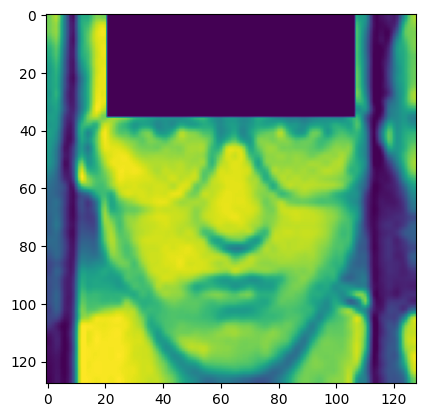

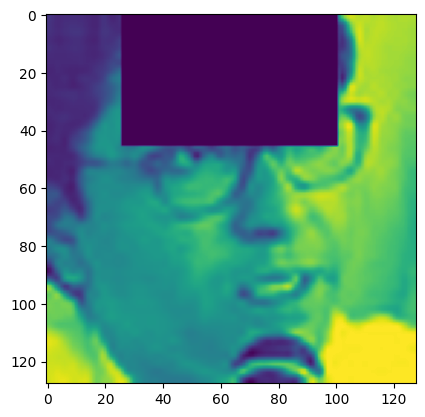

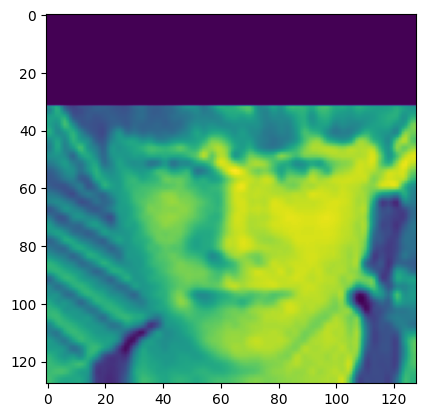

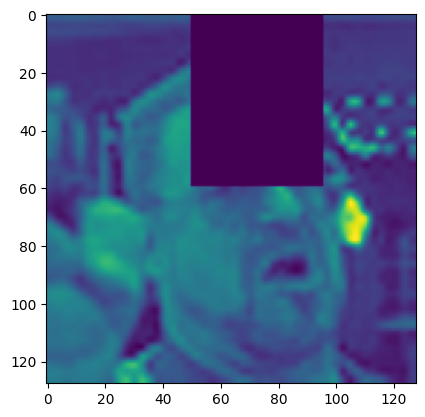

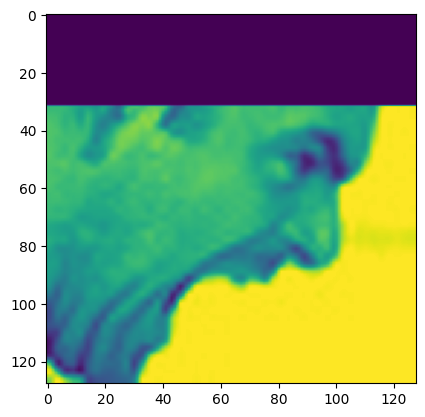

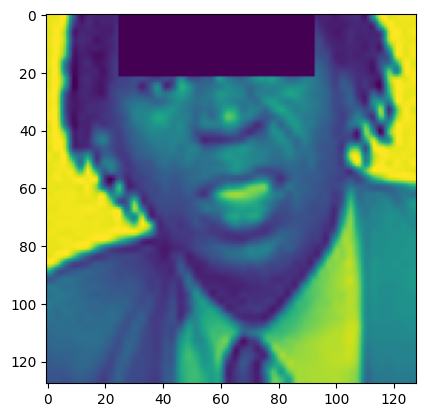

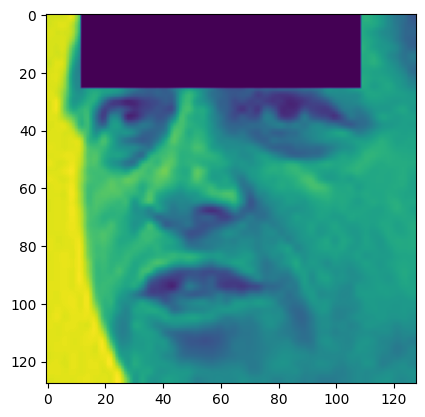

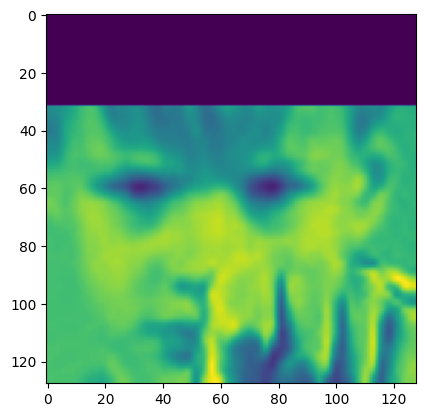

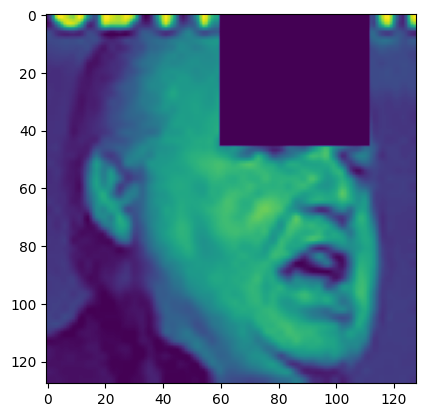

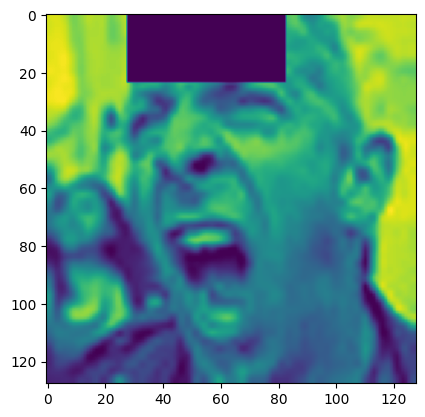

In [84]:
# Test apply forehead masks to some images
for i in range(0,10):
    img = x_data[i]
    plt.imshow(forehead_mask(img,128))
    plt.show()

In [ ]:
# Apply forehead masks to all images
x_data_forehead_masked = [forehead_mask(img,128) for img in x_data]
from numpy import save
# replace with your own directory
save('/content/gdrive/MyDrive/ML Final project/x_data_forehead_masked.npy', x_data_forehead_masked)

## Eyes

In [52]:
# Make a function to apply eye masks
def eye_mask(img,dim):
    # dlib face detection
    img = img.astype(np.uint8)
    detector = dlib.get_frontal_face_detector()
    detections = detector(img, 1)

    # Find landmarks
    sp = dlib.shape_predictor("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/shape_predictor_68_face_landmarks.dat")
    faces = dlib.full_object_detections()
    for det in detections:
        faces.append(sp(img, det))
    
    right_eyes = [[face.part(i) for i in range(36, 42)] for face in faces]
    right_eyes = [[(i.x, i.y) for i in eye] for eye in right_eyes]          # Convert out of dlib format

    left_eyes = [[face.part(i) for i in range(42, 48)] for face in faces]
    left_eyes = [[(i.x, i.y) for i in eye] for eye in left_eyes]            # Convert out of dlib format
    
    if right_eyes or left_eyes:
        for eye in left_eyes: # cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,255),2)
            l1 = max(eye, key=lambda x: x[0])[0]
            t1 = max(eye, key=lambda x: x[1])[1]
            r1 = min(eye, key=lambda x: x[0])[0]
            b1 = min(eye, key=lambda x: x[1])[1]

        for eye in right_eyes:
            l2 = max(eye, key=lambda x: x[0])[0]
            t2 = max(eye, key=lambda x: x[1])[1]
            r2 = min(eye, key=lambda x: x[0])[0]
            b2 = min(eye, key=lambda x: x[1])[1]
        l,t,r,b = max(l1,l2),max(t1,t2),min(r1,r2),min(b1,b2)
    else: # if open cv failed to detect eyes, then go with the middle 1/4 of the face
        r,l,b,t = 0,dim,int(dim/4),int(dim/2)
    
    if len(img.shape)==3:
        img = img.sum(axis=2)
    img[b:t,r:l] = 0
    return img

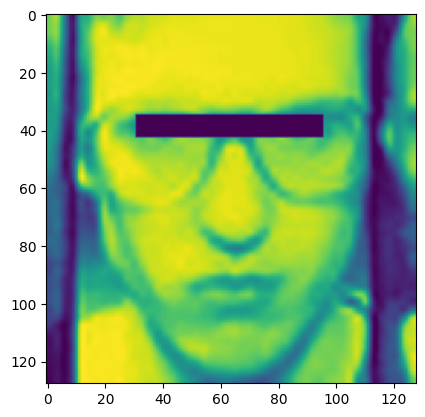

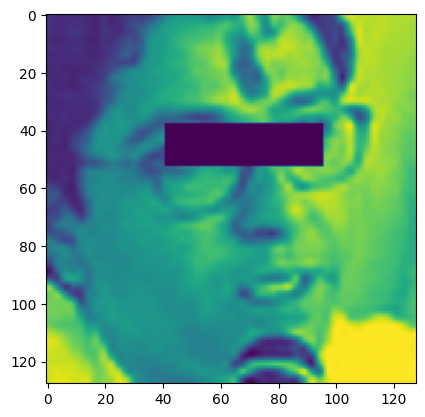

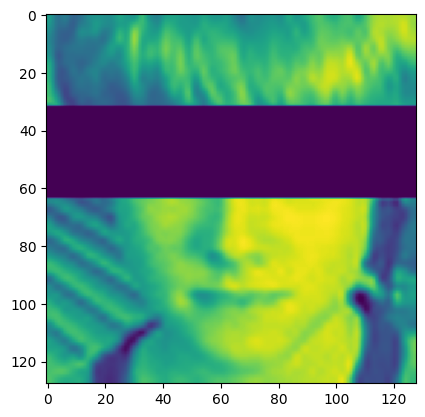

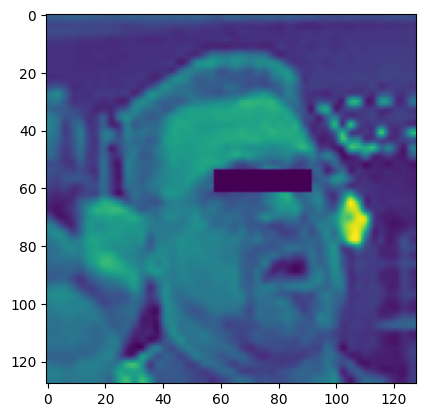

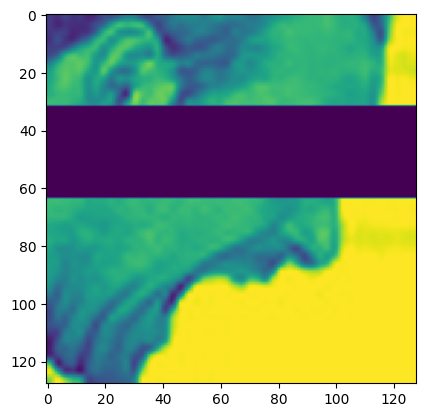

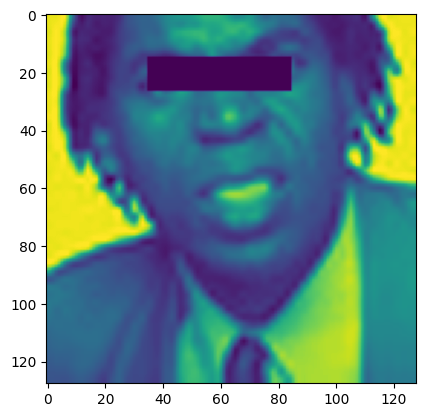

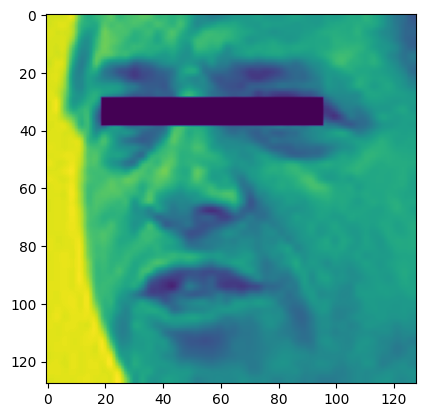

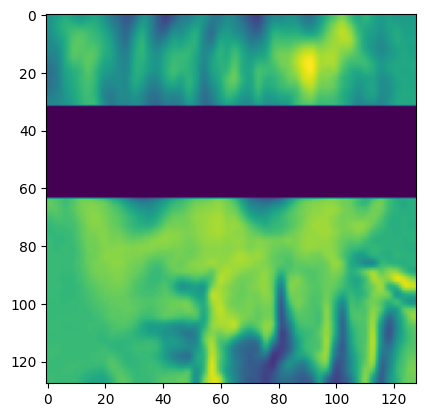

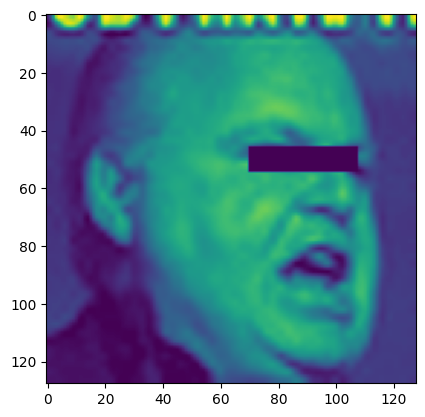

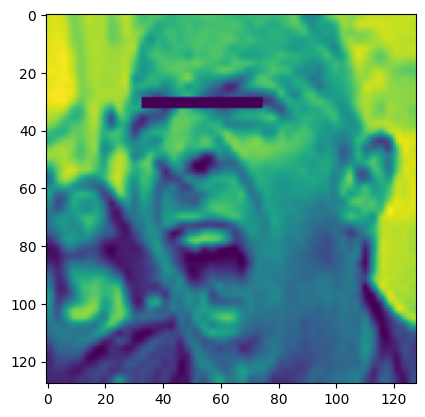

In [63]:
# Test apply eye masks to some images
for i in range(0,10):
    img = x_data[i]
    plt.imshow(eye_mask(img,128))
    plt.show()

In [ ]:
# Apply eye masks to all images
x_data_eye_masked = [eye_mask(img,128) for img in x_data]

In [ ]:
# save the masked images
from numpy import save
# replace with your own directory
save('/content/gdrive/MyDrive/ML Final project/x_data_eye_masked.npy', x_data)

## Eyebrow Mask

In [55]:
# Make a function to apply eyebrow masks
def eyebrows_mask(img,dim):
    # dlib face detection
    img = img.astype(np.uint8)
    detector = dlib.get_frontal_face_detector()
    detections = detector(img, 1)

    # Find landmarks
    # need to replace with your own directory
    sp = dlib.shape_predictor("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/shape_predictor_68_face_landmarks.dat")
    faces = dlib.full_object_detections()
    for det in detections:
        faces.append(sp(img, det))
    
    right_eyebrow = [[face.part(i) for i in range(17, 22)] for face in faces]
    right_eyebrow = [[(i.x, i.y) for i in eyebrow] for eyebrow in right_eyebrow]          # Convert out of dlib format

    left_eyebrow = [[face.part(i) for i in range(22, 27)] for face in faces]
    left_eyebrow = [[(i.x, i.y) for i in eyebrow] for eyebrow in left_eyebrow]            # Convert out of dlib format

    if right_eyebrow or left_eyebrow:
        for eyebrow in left_eyebrow:
            l1 = max(eyebrow, key=lambda x: x[0])[0]
            t1 = max(eyebrow, key=lambda x: x[1])[1]
            r1 = min(eyebrow, key=lambda x: x[0])[0]
            b1 = min(eyebrow, key=lambda x: x[1])[1]
        for eyebrow in right_eyebrow:
            l2 = max(eyebrow, key=lambda x: x[0])[0]
            t2 = max(eyebrow, key=lambda x: x[1])[1]
            r2 = min(eyebrow, key=lambda x: x[0])[0]
            b2 = min(eyebrow, key=lambda x: x[1])[1]
        l,t,r,b = max(l1,l2),max(t1,t2),min(r1,r2),min(b1,b2)
    
    else: # if open cv failed to detect eyebrows, then go with the middle 1/6 of the face
        r,l,b,t = 0,dim,int(dim/4),int(dim/2)
    
    if len(img.shape)==3:
        img = img.sum(axis=2)
    img[b:t,r:l] = 0
    return img

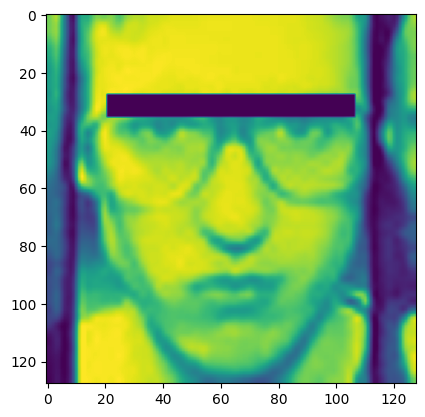

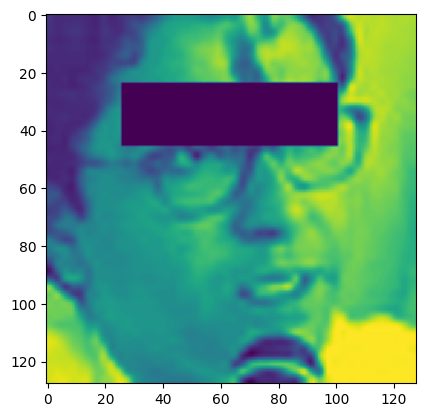

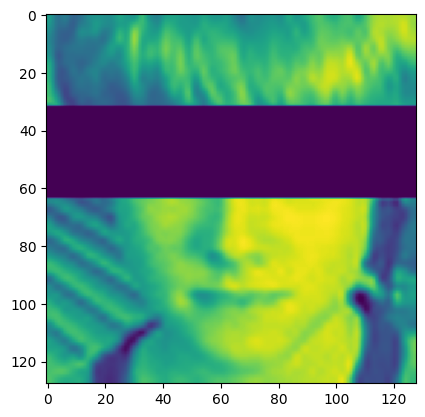

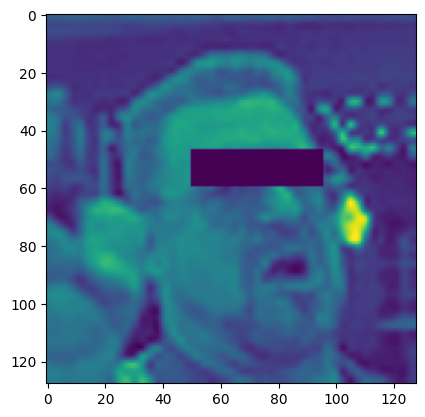

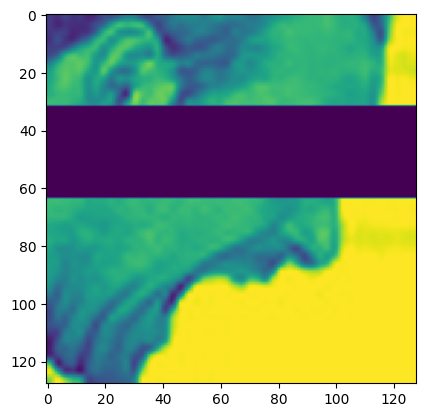

In [56]:
# Test apply eyebrow masks to some images
for i in range(0,5):
    img = x_data[i]
    plt.imshow(eyebrows_mask(img,128))
    plt.show()

## Eyebrow+Eye

In [66]:
# Make a function to apply eye and eyebrow masks
def eye_and_eyebrow(img,dim):
    # dlib face detection
    img = img.astype(np.uint8)
    detector = dlib.get_frontal_face_detector()
    detections = detector(img, 1)

    # Find landmarks
    # replace with your own directory
    sp = dlib.shape_predictor("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/shape_predictor_68_face_landmarks.dat")
    faces = dlib.full_object_detections()
    for det in detections:
        faces.append(sp(img, det))
    
    right_eyes = [[face.part(i) for i in range(36, 42)] for face in faces]
    right_eyes = [[(i.x, i.y) for i in eye] for eye in right_eyes]          # Convert out of dlib format

    left_eyes = [[face.part(i) for i in range(42, 48)] for face in faces]
    left_eyes = [[(i.x, i.y) for i in eye] for eye in left_eyes]            # Convert out of dlib format

    right_eyebrow = [[face.part(i) for i in range(17, 22)] for face in faces]
    right_eyebrow = [[(i.x, i.y) for i in eyebrow] for eyebrow in right_eyebrow]          # Convert out of dlib format

    left_eyebrow = [[face.part(i) for i in range(22, 27)] for face in faces]
    left_eyebrow = [[(i.x, i.y) for i in eyebrow] for eyebrow in left_eyebrow]            # Convert out of dlib format
    
    if (right_eyes or left_eyes) and (right_eyebrow or left_eyebrow):
        for eye in left_eyes: # cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,255),2)
            l1 = max(eye, key=lambda x: x[0])[0]
            t1 = max(eye, key=lambda x: x[1])[1]
            r1 = min(eye, key=lambda x: x[0])[0]
            b1 = min(eye, key=lambda x: x[1])[1]

        for eye in right_eyes:
            l2 = max(eye, key=lambda x: x[0])[0]
            t2 = max(eye, key=lambda x: x[1])[1]
            r2 = min(eye, key=lambda x: x[0])[0]
            b2 = min(eye, key=lambda x: x[1])[1]
    
        for eyebrow in left_eyebrow:
            l3 = max(eyebrow, key=lambda x: x[0])[0]
            t3 = max(eyebrow, key=lambda x: x[1])[1]
            r3 = min(eyebrow, key=lambda x: x[0])[0]
            b3 = min(eyebrow, key=lambda x: x[1])[1]
        for eyebrow in right_eyebrow:
            l4 = max(eyebrow, key=lambda x: x[0])[0]
            t4 = max(eyebrow, key=lambda x: x[1])[1]
            r4 = min(eyebrow, key=lambda x: x[0])[0]
            b4 = min(eyebrow, key=lambda x: x[1])[1]
        l,t,r,b = max(l1,l2,l3,l4),max(t1,t2,t3,t4),min(r1,r2,r3,r4),min(b1,b2,b3,b4)
    else: # if open cv failed to detect eyes, then go with the middle 1/4 of the face
        r,l,b,t = 0,dim,int(dim/4),int(dim/2)
    
    if len(img.shape)==3:
        img = img.sum(axis=2)
    img[b:t,r:l] = 0
    return img

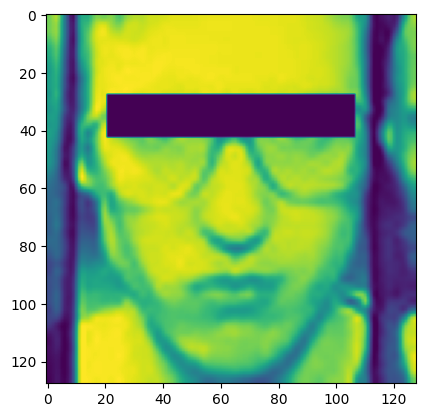

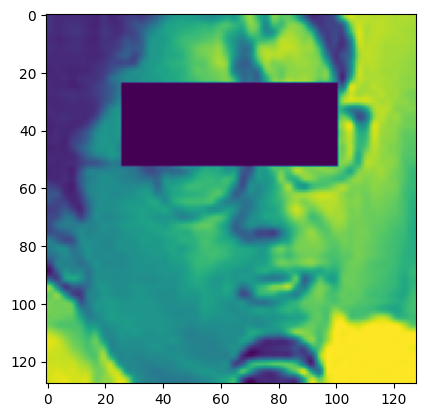

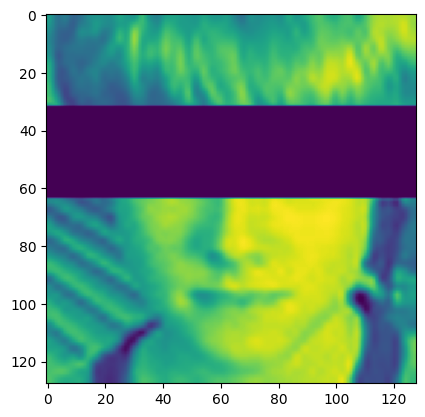

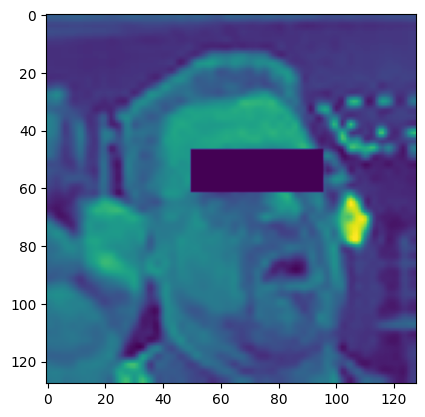

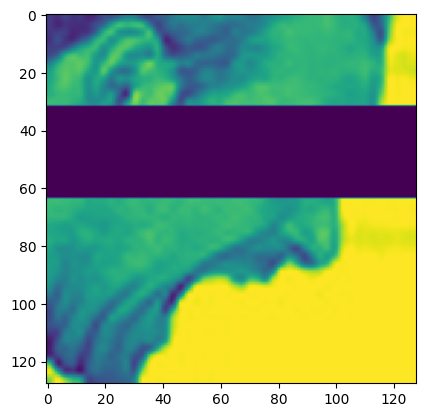

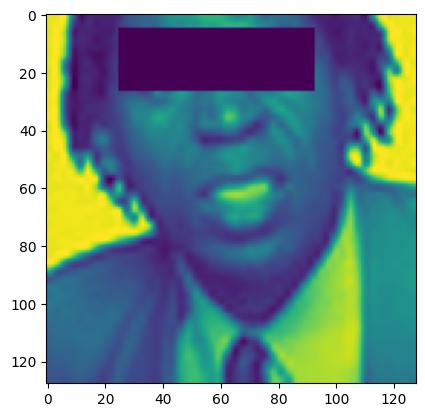

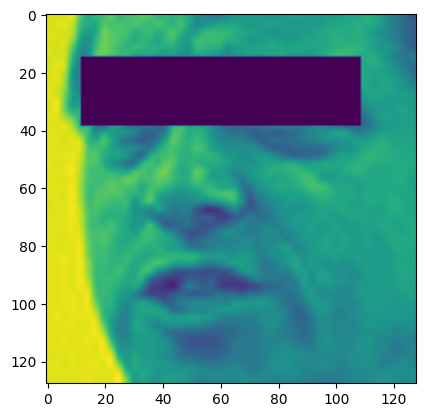

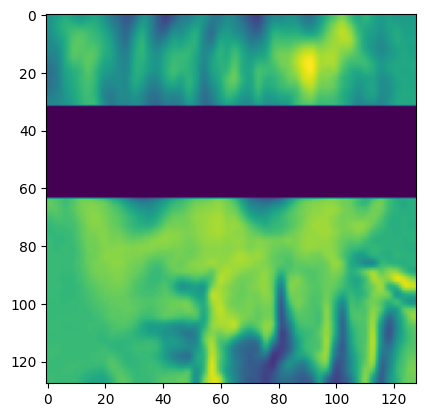

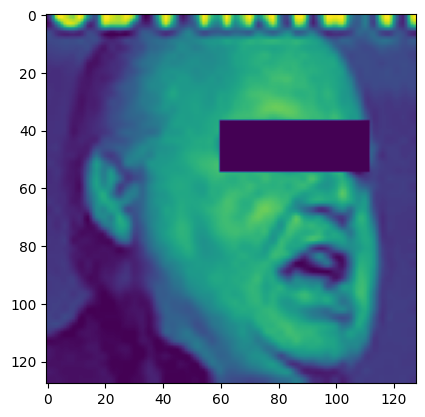

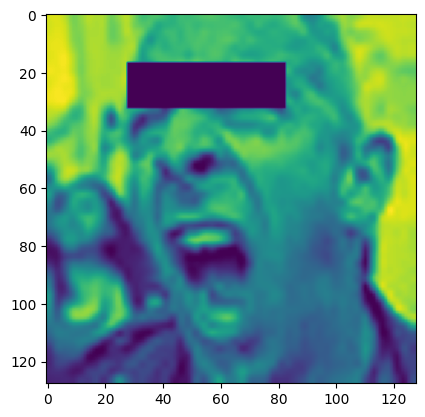

In [67]:
# Test apply eye and eyebrow masks to some images
for i in range(0,10):
    img = x_data[i]
    plt.imshow(eye_and_eyebrow(img,128))
    plt.show()

In [ ]:
# Apply eye and eyebrow masks to all images
x_data_eye_area_masked = [eye_and_eyebrow(img,128) for img in x_data]

In [ ]:
# Save the masked images
from numpy import save
# replace with your own directory
save('/content/gdrive/MyDrive/ML Final project/x_data_eye_area_masked.npy', x_data_eye_area_masked)

## Nose + Mouth Mask

In [79]:
# Make a function to apply nose and mouth masks
def nose_mouth_mask(img,dim):
    # dlib face detection
    img = img.astype(np.uint8)
    detector = dlib.get_frontal_face_detector()
    detections = detector(img, 1)

    # Find landmarks
    # need to replace with your own directory
    sp = dlib.shape_predictor("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/shape_predictor_68_face_landmarks.dat")
    faces = dlib.full_object_detections()
    for det in detections:
        faces.append(sp(img, det))
    
    nose = [[face.part(i) for i in range(27, 35)] for face in faces]
    nose = [[(i.x, i.y) for i in n] for n in nose]          # Convert out of dlib format

    mouth = [[face.part(i) for i in range(48, 68)] for face in faces]
    mouth = [[(i.x, i.y) for i in m] for m in mouth]          # Convert out of dlib format

    if nose or mouth:
        for n in nose:
            l1 = max(n, key=lambda x: x[0])[0]
            t1 = max(n, key=lambda x: x[1])[1]
            r1 = min(n, key=lambda x: x[0])[0]
            b1 = min(n, key=lambda x: x[1])[1]
    

        for m in mouth:
            l2 = max(m, key=lambda x: x[0])[0]
            t2 = max(m, key=lambda x: x[1])[1]
            r2 = min(m, key=lambda x: x[0])[0]
            b2 = min(m, key=lambda x: x[1])[1]
        l,t,r,b = max(l1,l2),max(int(t1*1.5),t2),min(r1,r2),min(int(b1*1.5),b2)
    else: # if open cv failed to detect eyes, then go with the middle 1/4 of the face
        r,l,b,t = 0,dim,int(dim/2),int(dim)
    
    if len(img.shape)==3:
        img = img.sum(axis=2)
    img[b:t,r:l] = 0
    return img

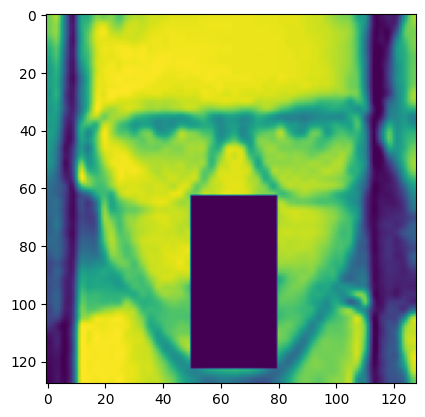

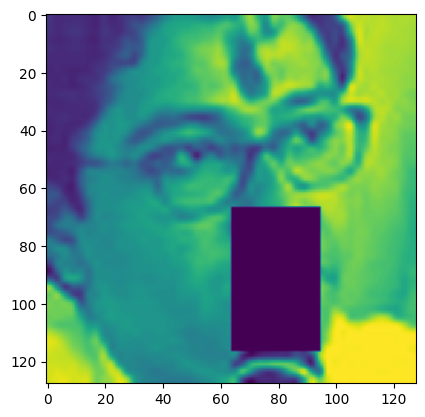

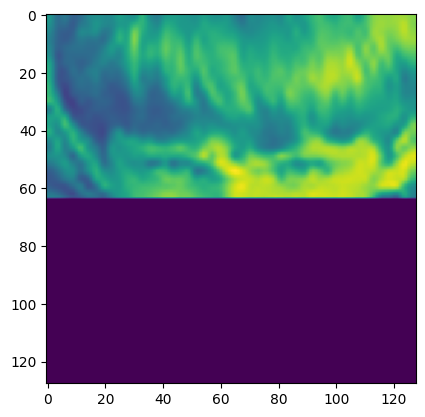

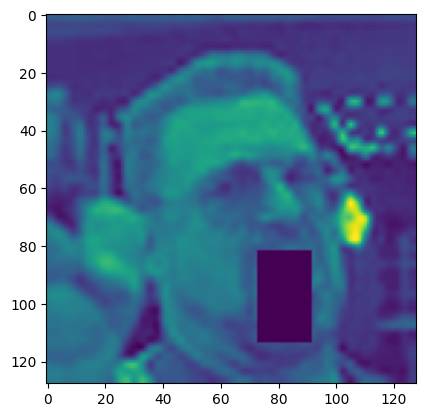

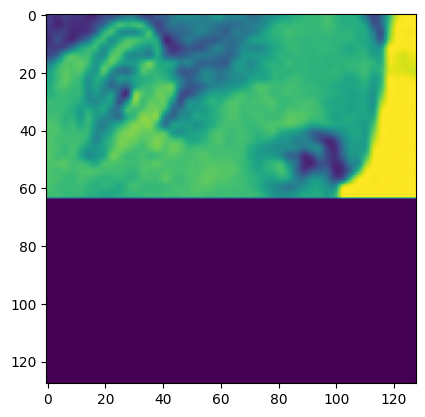

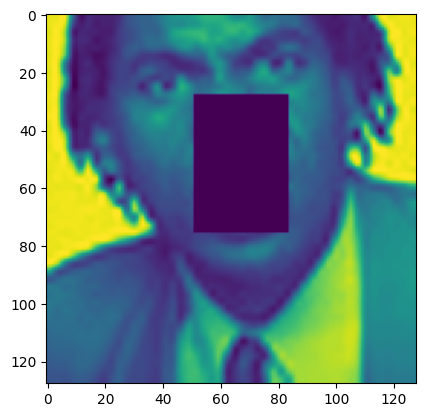

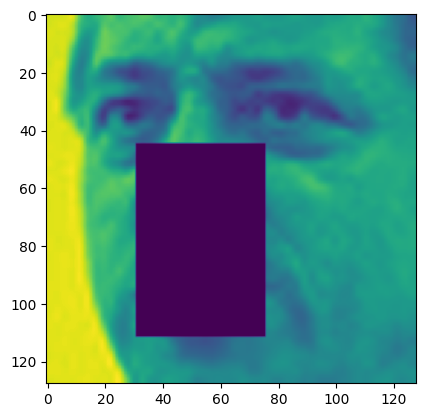

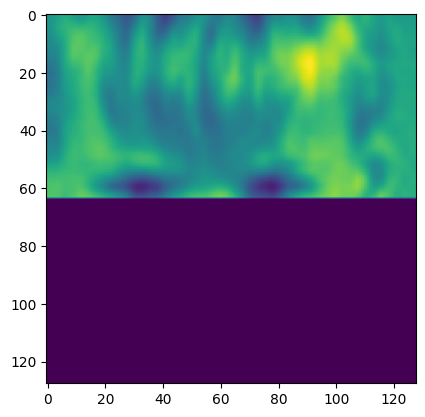

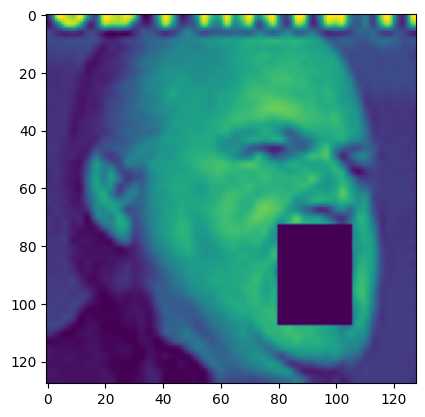

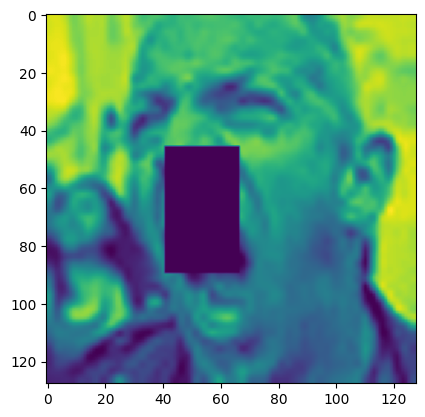

In [80]:
# Test apply nose and mouth masks to some images
for i in range(0,10):
    img = x_data[i]
    plt.imshow(nose_mouth_mask(img,128))
    plt.show()

In [ ]:
# apply nose and mouth masks to all images
x_data_bottom_masked = [eye_mask(img,128) for img in x_data]

# Save the masked images
from numpy import save
# replace with your own directory
save('/content/gdrive/MyDrive/ML Final project/x_data_bottom_masked.npy', x_data_bottom_masked)

## Nose Mask

In [68]:
# Make a function to apply nose mask
def nose_mask(img,dim):
    # dlib face detection
    img = img.astype(np.uint8)
    detector = dlib.get_frontal_face_detector()
    detections = detector(img, 1)

    # Find landmarks
    # need to replace with your own directory
    sp = dlib.shape_predictor("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/shape_predictor_68_face_landmarks.dat")
    faces = dlib.full_object_detections()
    for det in detections:
        faces.append(sp(img, det))
    
    nose = [[face.part(i) for i in range(27, 35)] for face in faces]
    nose = [[(i.x, i.y) for i in n] for n in nose]          # Convert out of dlib format
    if nose:
      for n in nose:
          # l = max(n, key=lambda x: x[0])[0]
          t = max(n, key=lambda x: x[1])[1]
          # r = min(n, key=lambda x: x[0])[0]
          b = min(n, key=lambda x: x[1])[1]
          r = 0
          l = 255
    else: # if open cv failed to detect eyes, then go with the middle 1/4 of the face
        r,l,b,t = 0,dim,int(dim/2),int(dim*3/4)
    
    if len(img.shape)==3:
        img = img.sum(axis=2)
    img[b:t,r:l] = 0
    return img

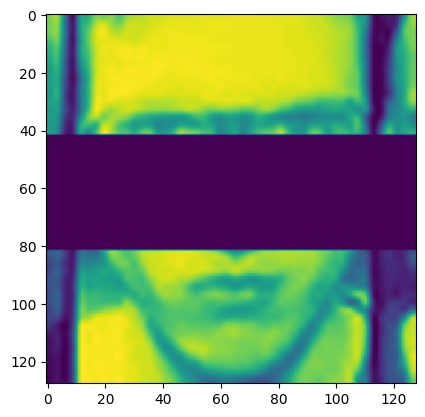

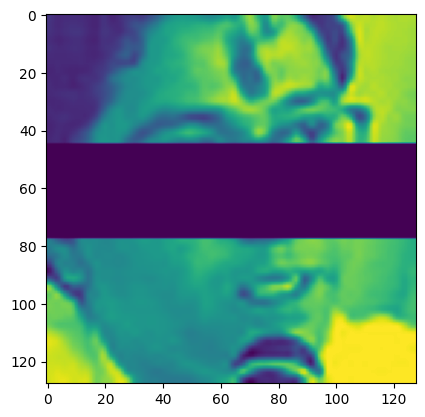

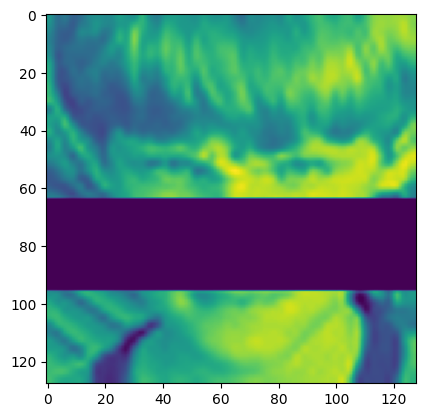

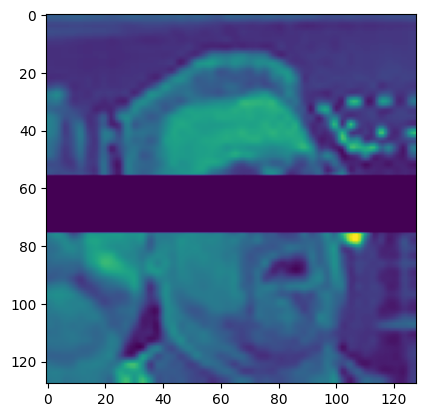

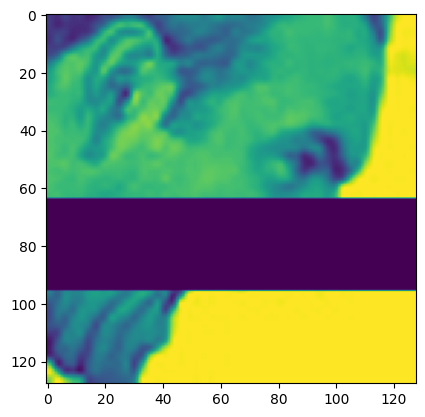

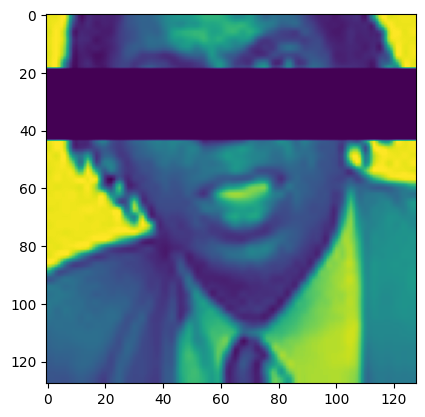

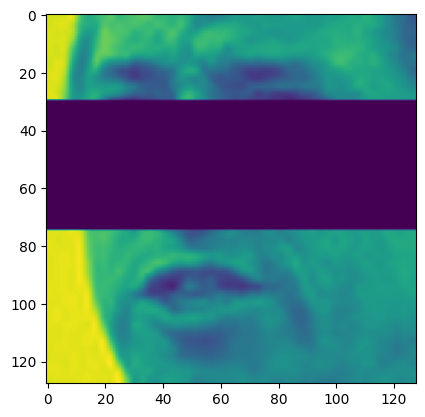

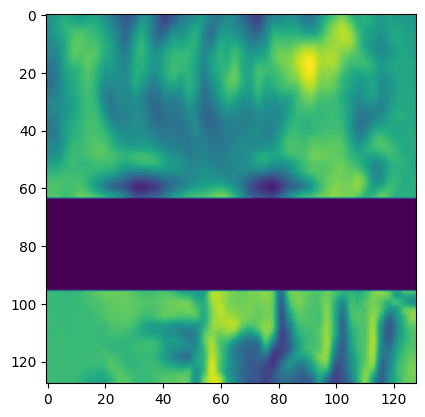

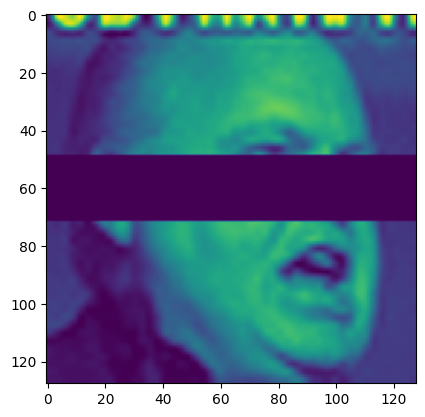

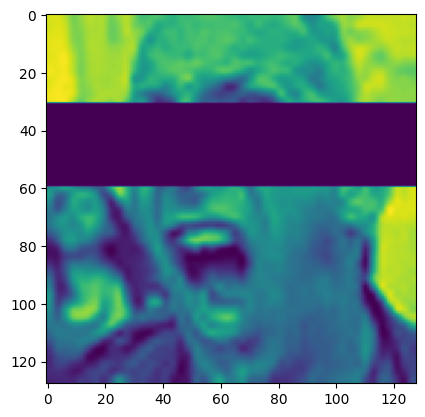

In [69]:
# Test apply nose mask to some images
for i in range(0,10):
    img = x_data[i]
    plt.imshow(nose_mask(img,128))
    plt.show()

In [70]:
# Make a function to apply nose mask
def nose_mask(img,dim):
    # dlib face detection
    img = img.astype(np.uint8)
    detector = dlib.get_frontal_face_detector()
    detections = detector(img, 1)

    # Find landmarks
    # need to replace with your own directory
    sp = dlib.shape_predictor("/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/shape_predictor_68_face_landmarks.dat")
    faces = dlib.full_object_detections()
    for det in detections:
        faces.append(sp(img, det))
    
    nose = [[face.part(i) for i in range(27, 35)] for face in faces]
    nose = [[(i.x, i.y) for i in n] for n in nose]          # Convert out of dlib format
    if nose:
      for n in nose:
          l = max(n, key=lambda x: x[0])[0]
          t = max(n, key=lambda x: x[1])[1]
          r = min(n, key=lambda x: x[0])[0]
          b = min(n, key=lambda x: x[1])[1]
          # r = 0
          # l = 255
    else: # if open cv failed to detect eyes, then go with the middle 1/4 of the face
        r,l,b,t = 0,dim,int(dim/2),int(dim*3/4)
    
    if len(img.shape)==3:
        img = img.sum(axis=2)
    img[b:t,r:l] = 0
    return img

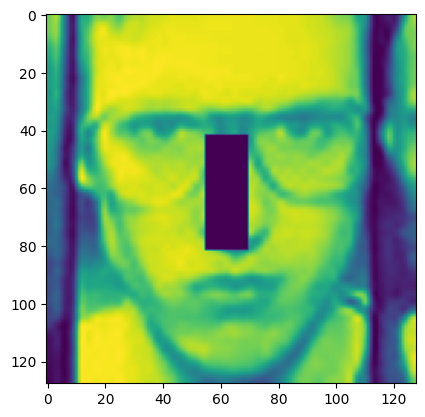

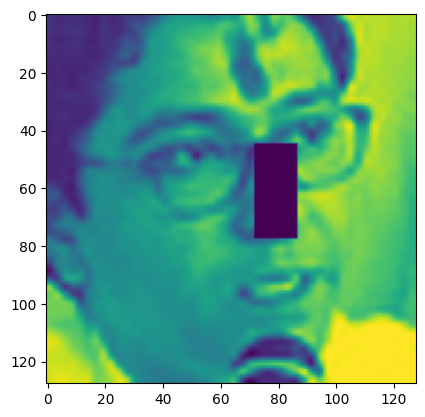

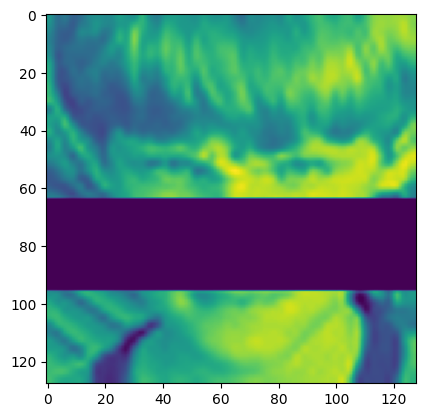

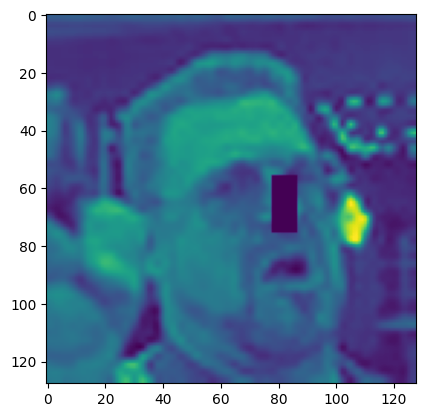

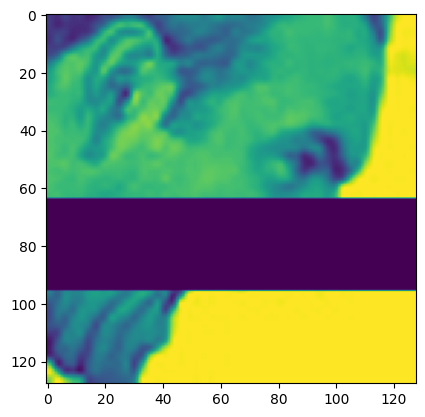

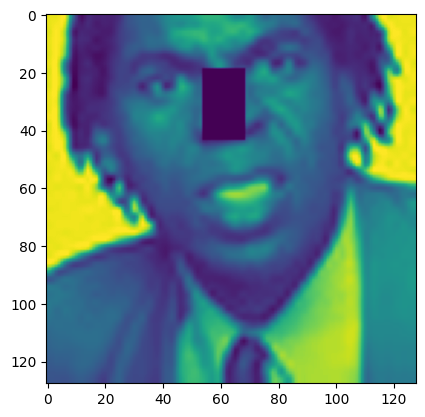

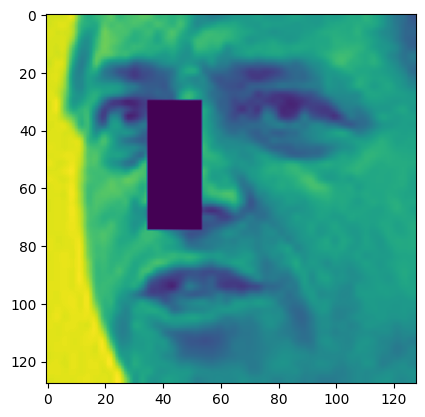

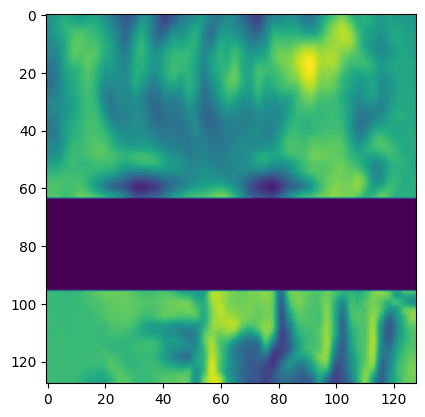

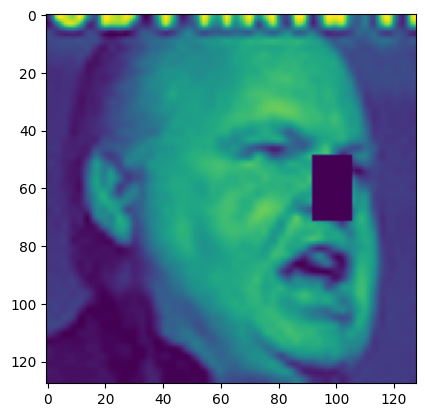

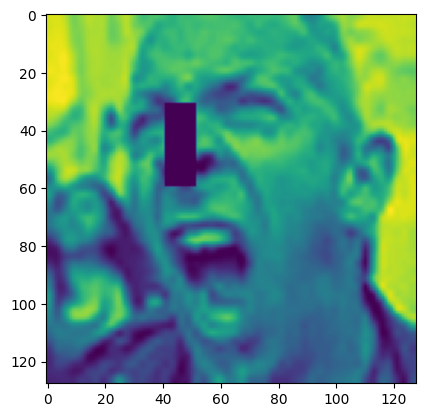

In [71]:
# Test apply nose mask to some images
for i in range(0,10):
    img = x_data[i]
    plt.imshow(nose_mask(img,128))
    plt.show()